## 1: Data

Credit to the demo notebook

In [1]:
import json
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

np.random.seed(123)
sns.set_style('darkgrid')
pd.set_option('display.max_colwidth', None)

In [2]:
def describe_column(meta):
    """
    Utility function for describing a dataset column (see below for usage)
    """
    def f(x):
        d = pd.Series(name=x.name, dtype=object)
        m = next(m for m in meta if m['name'] == x.name)
        d['Type'] = m['type']
        d['#NaN'] = x.isna().sum()
        d['Description'] = m['desc']
        if m['type'] == 'categorical':
            counts = x.dropna().map(dict(enumerate(m['cats']))).value_counts().sort_index()
            d['Statistics'] = ', '.join(f'{c}({n})' for c, n in counts.items())
        elif m['type'] == 'real' or m['type'] == 'integer':
            stats = x.dropna().agg(['mean', 'std', 'min', 'max'])
            d['Statistics'] = ', '.join(f'{s}={v :.1f}' for s, v in stats.items())
        elif m['type'] == 'boolean':
            counts = x.dropna().astype(bool).value_counts().sort_index()
            d['Statistics'] = ', '.join(f'{c}({n})' for c, n in counts.items())
        else:
            d['Statistics'] = f'#unique={x.nunique()}'
        return d
    return f

def describe_data(data, meta):
    desc = data.apply(describe_column(meta)).T
    desc = desc.style.set_properties(**{'text-align': 'left'})
    desc = desc.set_table_styles([ dict(selector='th', props=[('text-align', 'left')])])
    return desc 

In [3]:
apartments = pd.read_csv('data/apartments_train.csv')
print(f'Loaded {len(apartments)} apartments')
with open('data/apartments_meta.json') as f: 
    apartments_meta = json.load(f)
describe_data(apartments, apartments_meta)

Loaded 23285 apartments


,Type,#NaN,Description,Statistics
id,integer_id,0,Unique ID for apartment,#unique=23285
seller,categorical,8830,The type of apartment seller,"Agents(1895), Company(4768), Developer(6185), Owner(1607)"
price,real,0,The listed price of the apartment (TARGET),"mean=23556173.5, std=52643927.8, min=900000.0, max=2600000000.0"
area_total,real,0,Total area of the apartment,"mean=74.5, std=58.7, min=9.3, max=2181.0"
area_kitchen,real,4721,Total kitchen area in the apartment,"mean=12.6, std=6.6, min=1.0, max=100.0"
area_living,real,3882,Total living space area in the apartment,"mean=38.7, std=31.4, min=0.0, max=900.0"
floor,integer,0,Primary building floor of the apartment,"mean=9.0, std=8.3, min=1.0, max=95.0"
rooms,integer,0,Number of rooms in the apartment,"mean=2.2, std=1.1, min=1.0, max=6.0"
layout,categorical,17642,Overal apartment layout,"Adjacent(241), Adjacent_isolated(465), Isolated(4937)"
ceiling,real,11093,Ceiling height in the apartment,"mean=3.3, std=10.8, min=0.0, max=340.0"


In [4]:
buildings = pd.read_csv('data/buildings_train.csv')
print(f'Loaded {len(buildings)} buildings')
with open('data/buildings_meta.json') as f: 
    buildings_meta = json.load(f)
buildings.head()
describe_data(buildings, buildings_meta)

Loaded 6791 buildings


,Type,#NaN,Description,Statistics
id,integer_id,0,Unique ID of building for joining with apartments,#unique=6791
new,boolean,227,Whether it is an old or new building,"False(6141), True(423)"
latitude,real,0,Latitude coordinate of building,"mean=55.7, std=0.1, min=55.2, max=56.0"
longitude,real,0,Longitude coordinate of building,"mean=37.6, std=0.2, min=36.9, max=38.0"
district,categorical,1,Administriative district within Moscow,"Central(637), East(956), North(593), North-East(630), North-West(553), Novomoskovsk(344), South(758), South-East(672), South-West(900), Troitsk(146), West(535), Zelenograd(66)"
street,string,0,Bulding street name,#unique=1682
address,string,0,Building address (within street),#unique=1851
constructed,integer,479,Year when the building was constructed,"mean=1985.8, std=24.3, min=1855.0, max=2023.0"
material,categorical,1165,Primary building material used in building,"Block(679), Bricks(1226), Monolith(1312), Monolithic_brick(19), Panel(2384), Stalin_project(2), Wood(4)"
stories,integer,0,Total number of floors in the building,"mean=13.0, std=7.0, min=1.0, max=95.0"


In [34]:
print(f'All apartments have an associated building: {apartments.building_id.isin(buildings.id).all()}')
data = pd.merge(apartments, buildings.set_index('id'), how='left', left_on='building_id', right_index=True)
data.head()

apartments_test = pd.read_csv('data/apartments_test.csv')
buildings_test = pd.read_csv('data/buildings_test.csv')
print(f'All test apartments have an associated building: {apartments_test.building_id.isin(buildings_test.id).all()}')
data_test = pd.merge(apartments_test, buildings_test.set_index('id'), how='left', left_on='building_id', right_index=True)
print(f'Number of train samples: {len(data)}')
print(f'Number of test samples:  {len(data_test)}')
data_test.head()

All apartments have an associated building: True
All test apartments have an associated building: True
Number of train samples: 23285
Number of test samples:  9937


,id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,23285,NaN,71.4,NaN,NaN,2.0,1.0,NaN,NaN,NaN,...,6к3,2017.0,2.0,20.0,1.0,1.0,1.0,NaN,1.0,0.0
1,23286,NaN,54.0,4.0,50.0,4.0,1.0,NaN,3.00,NaN,...,3к2,2017.0,2.0,15.0,0.0,1.0,1.0,0.0,0.0,0.0
2,23287,3.0,39.4,19.6,11.2,10.0,1.0,NaN,2.65,1.0,...,27,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
3,23288,NaN,60.9,NaN,NaN,5.0,2.0,1.0,NaN,1.0,...,23,2014.0,2.0,17.0,1.0,1.0,0.0,NaN,1.0,3.0
4,23289,NaN,34.0,9.0,17.0,14.0,1.0,NaN,2.75,1.0,...,13к1,2016.0,2.0,17.0,0.0,1.0,1.0,NaN,1.0,0.0


## 2. EDA

/home/henrik/ms1/ml/tdt4173-2021-task-1-main/tdt4173/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness: 19.152175
Kurtosis: 716.628490


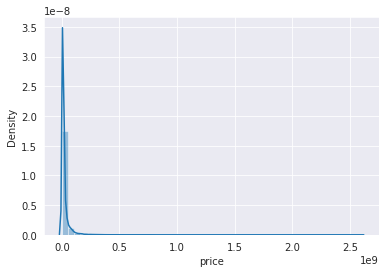

In [6]:
# descibing the target
sns.distplot(apartments['price']);

#skewness and kurtosis
print("Skewness: %f" % apartments['price'].skew())
print("Kurtosis: %f" % apartments['price'].kurt())


Skewness measures how symmetric it is, and a positive number means it is skewed to the right. The distribution plot also shows how the long tail creates a right-skewed price distribution. Taking the log() of the price might help

kurtosis

id                   -0.027967
seller                0.101015
price                 1.000000
area_total            0.814829
area_kitchen          0.364758
area_living           0.707580
floor                 0.132206
rooms                 0.411317
layout                0.130822
ceiling               0.031640
bathrooms_shared      0.332421
bathrooms_private     0.133364
windows_court        -0.005345
windows_street        0.180263
balconies             0.102928
loggias               0.024877
condition             0.109338
phones                0.042738
building_id           0.052159
new                  -0.089292
latitude              0.054341
longitude            -0.034022
district             -0.182404
constructed           0.047633
material             -0.100614
stories               0.086448
elevator_without      0.162024
elevator_passenger    0.021846
elevator_service      0.024681
parking              -0.199476
garbage_chute         0.029171
heating               0.087359
Name: pr

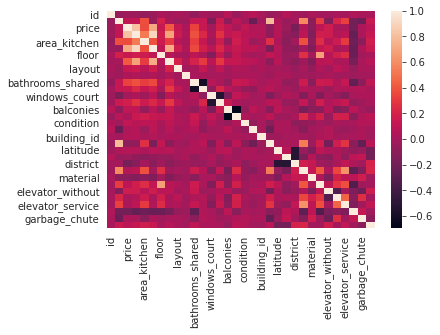

In [7]:
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, square=False);

correlation_matrix
correlation_matrix.style.background_gradient(cmap='coolwarm')

correlation_matrix.price

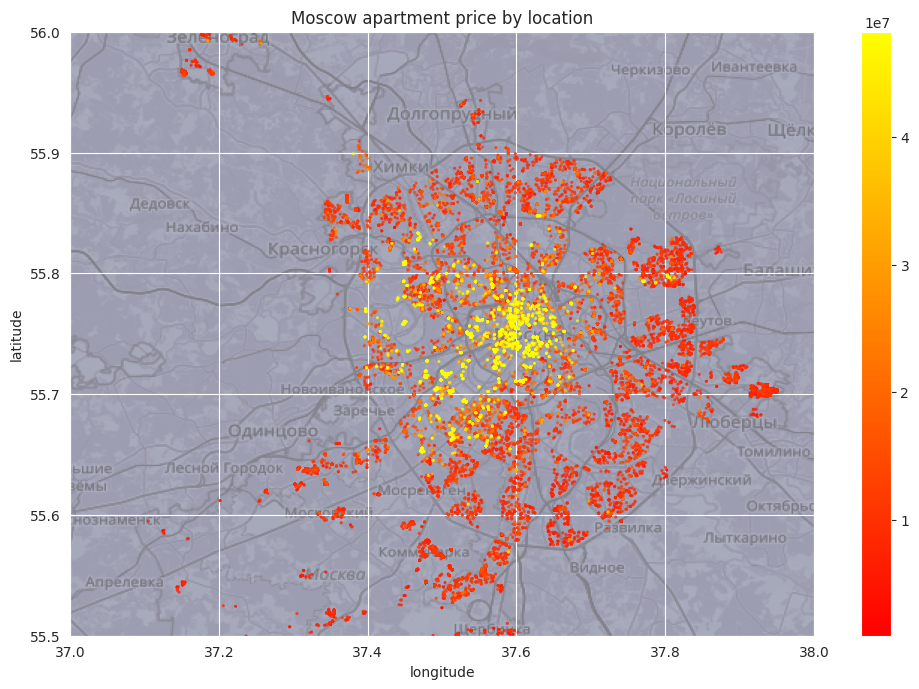

In [8]:
# geographical data (credit to Introduction Notebook)
def plot_map(data, ax=None, s=5, a=0.75, q_lo=0.0, q_hi=0.9, cmap='autumn', column='price', title='Moscow apartment price by location'):
    data = data[['latitude', 'longitude', column]].sort_values(by=column, ascending=True)
    backdrop = plt.imread('data/moscow.png')
    backdrop = np.einsum('hwc, c -> hw', backdrop, [0, 1, 0, 0]) ** 2
    if ax is None:
        plt.figure(figsize=(12, 8), dpi=100)
        ax = plt.gca()
    discrete = data[column].nunique() <= 20
    if not discrete:
        lo, hi = data[column].quantile([q_lo, q_hi])
        hue_norm = plt.Normalize(lo, hi)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(lo, hi))
        sm.set_array([])
    else:
        hue_norm = None 
    ax.imshow(backdrop, alpha=0.5, extent=[37, 38, 55.5, 56], aspect='auto', cmap='bone', norm=plt.Normalize(0.0, 2))
    sns.scatterplot(x='longitude', y='latitude', hue=data[column].tolist(), ax=ax, s=s, alpha=a, palette=cmap,linewidth=0, hue_norm=hue_norm, data=data)
    ax.set_xlim(37, 38)    # min/max longitude of image 
    ax.set_ylim(55.5, 56)  # min/max latitude of image
    if not discrete:
        ax.legend().remove()
        ax.figure.colorbar(sm)
    ax.set_title(title)
    return ax, hue_norm

plot_map(data);

Number of missing price entries in train data: 0
Training set features with any missing value: 23/34
Testing set features with any missing value: 25/33


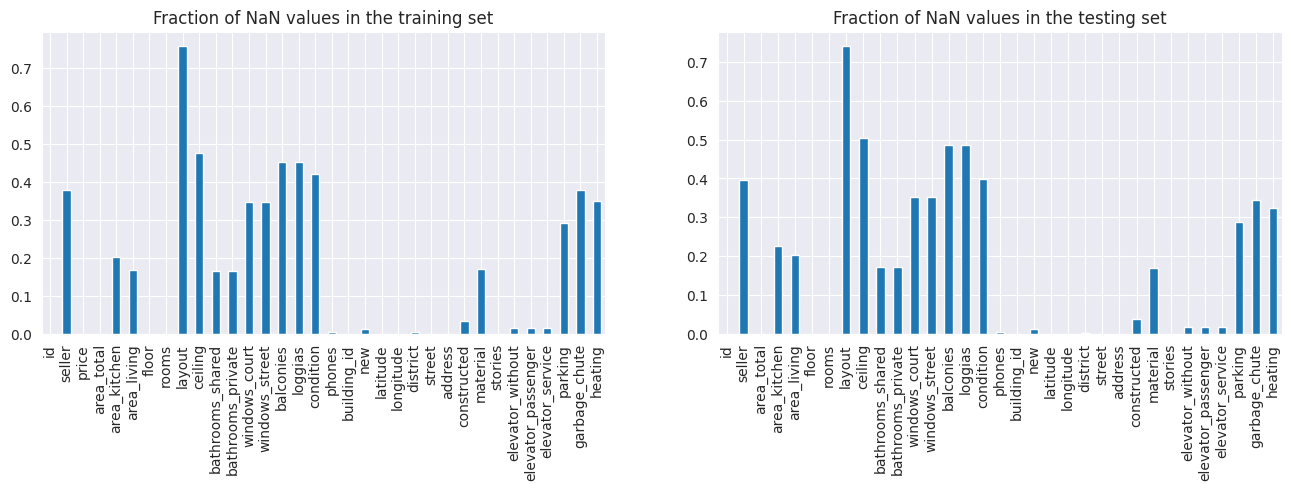

In [9]:
# Missing values (credit to Introduction Notebook)
fig, (ax1, ax2) = plt.subplots(figsize=(16, 4), ncols=2, dpi=100)
print(f'Number of missing price entries in train data: {data.price.isna().sum()}')
print(f'Training set features with any missing value: {data.isna().any().sum()}/{data.shape[1]}')
print(f'Testing set features with any missing value: {data_test.isna().any().sum()}/{data_test.shape[1]}')
data.isna().mean().plot.bar(ax=ax1, title='Fraction of NaN values in the training set')
data_test.isna().mean().plot.bar(ax=ax2, title='Fraction of NaN values in the testing set');

The correlation between the price and area_total and area_living is the highest. These variables have multicollinearity and one of them could be exluded from predictions. Rooms and area_living also has a high multicollinearity and could be pruned

## 3. Feature engineering

Suggestions/Things to try:
1. Try including/excluding different variables
1. Handle missing values in a better way
1. Normalize and other things

Foreløpig bruker jeg kun features i features-listen og sletter alle sampel som har minst en nan. Det gir en validation score på 0.1749 for random forest

In [59]:
import sklearn.model_selection as model_selection

# which features to include in the model
features = ['price' ,'latitude', 'longitude', 'area_total', 'floor', 'rooms', 'elevator_without', 'stories', 'constructed', 'district']                

data_features = data[features] # remove unwanted columns
data_features = data_features.dropna() # removes all rows containing NaN
data_train, data_valid = model_selection.train_test_split(data_features, test_size=0.33, stratify=np.log(data_features.price).round())

X_train = data_train[features[1:]] 
Y_train = data_train.price

X_test = data_valid[features[1:]]
Y_test = data_valid.price
print(f'Num nans in train {X_train.isna().any(axis=1).sum()}')
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape


Num nans in train 0


((14885, 9), (14885,), (7332, 9), (7332,))

In [60]:
data_features.latitude

0        55.544046
1        55.861282
2        55.663299
3        55.861282
4        55.590785
           ...    
23279    55.807461
23280    55.770775
23281    55.785777
23282    55.753686
23283    55.611302
Name: latitude, Length: 22217, dtype: float64

## 4. Modelling

Beste hittil er Valid RMSLE: 0.1691 for XGboost


In [61]:
# importing models
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

In [62]:
# loss used to evaluate the model
def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

In [40]:
# decision tree
model = DecisionTreeRegressor(max_depth=25).fit(X_train, Y_train)
y_train_hat = model.predict(X_train)
y_valid_hat = model.predict(X_test)

print(f'Train RMSLE: {root_mean_squared_log_error(y_true=Y_train, y_pred=y_train_hat) :.4f}')
print(f'Valid RMSLE: {root_mean_squared_log_error(y_true=Y_test, y_pred=y_valid_hat) :.4f}')

Train RMSLE: 0.0140
Valid RMSLE: 0.2220


In [63]:
# random forest
clf = RandomForestRegressor(max_depth=25, random_state=0)
clf.fit(X_train, Y_train)
y_train_hat = clf.predict(X_train)
y_valid_hat = clf.predict(X_test)
y_train_hat[y_train_hat<0]=0 
y_valid_hat[y_valid_hat<0]=0 
print(f'Train RMSLE: {root_mean_squared_log_error(y_true=Y_train, y_pred=y_train_hat) :.4f}')
print(f'Valid RMSLE: {root_mean_squared_log_error(y_true=Y_test, y_pred=y_valid_hat) :.4f}')

Train RMSLE: 0.0734
Valid RMSLE: 0.1645


<BarContainer object of 9 artists>

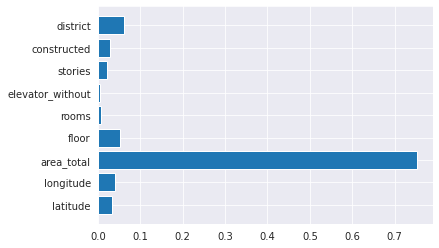

In [64]:
plt.barh(features[1:], clf.feature_importances_) # plot feature importances

In [42]:
# Gradient booster
reg = GradientBoostingRegressor(random_state=0, max_depth=25)
reg.fit(X_train, Y_train)
y_train_hat = reg.predict(X_train)
y_valid_hat = reg.predict(X_test)
y_train_hat[y_train_hat<0]=0 
y_valid_hat[y_valid_hat<0]=0 
print(f'Train RMSLE: {root_mean_squared_log_error(y_true=Y_train, y_pred=y_train_hat) :.4f}')
print(f'Valid RMSLE: {root_mean_squared_log_error(y_true=Y_test, y_pred=y_valid_hat) :.4f}')

Train RMSLE: 0.0090
Valid RMSLE: 0.2103


In [ ]:
# xgboost
model_xgb = xgb.XGBRFRegressor(random_state=0, max_depth=25).fit(
    X_train, Y_train)
model_xgb.fit(X_train, Y_train)
y_train_hat=model_xgb.predict(X_train)
y_valid_hat=model_xgb.predict(X_test)

#y_valid_hat[y_valid_hat<0]=0 
print(f'Train RMSLE: {root_mean_squared_log_error(y_true=Y_train, y_pred=y_train_hat) :.4f}')
print(f'Valid RMSLE: {root_mean_squared_log_error(y_true=Y_test, y_pred=y_valid_hat) :.4f}')

In [62]:
# lasso has really bad results, but can be good with heavy feature engineering
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=0))
lasso.fit(X_train, Y_train)
y_train_hat = lasso.predict(X_train)
y_valid_hat = lasso.predict(X_test)
y_valid_hat[y_valid_hat<0]=0 
y_train_hat[y_train_hat<0]=0
print(f'Train RMSLE: {root_mean_squared_log_error(y_true=Y_train, y_pred=y_train_hat) :.4f}')
print(f'Valid RMSLE: {root_mean_squared_log_error(y_true=Y_test, y_pred=y_valid_hat) :.4f}')

Train RMSLE: 4.9673
Valid RMSLE: 5.0683


In [63]:
# similar to lasso
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=0))
ENet.fit(X_train, Y_train)
y_train_hat = ENet.predict(X_train)
y_valid_hat = ENet.predict(X_test)
y_valid_hat[y_valid_hat<0]=0 
y_train_hat[y_train_hat<0]=0
print(f'Train RMSLE: {root_mean_squared_log_error(y_true=Y_train, y_pred=y_train_hat) :.4f}')
print(f'Valid RMSLE: {root_mean_squared_log_error(y_true=Y_test, y_pred=y_valid_hat) :.4f}')

Train RMSLE: 4.9670
Valid RMSLE: 5.0656
